### Exercise-3 Network Regularization

In [15]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
import numpy as np
from torch.utils.data import DataLoader
import torch.utils.data
import torch.nn.functional as F
import torchvision.transforms as transforms

from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d

from torch.utils.tensorboard import SummaryWriter
torch.set_printoptions(linewidth=120)

In [31]:
# Hyperparameters
num_epochs = 6
num_classes = 10
batch_size = 100
learning_rate = 0.001

DATA_PATH = '/home/jaishree/Documents/DA Sem 1/DDA Lab/CNN_image_classification/cifar-10'
MODEL_PATH = '/home/jaishree/Documents/DA Sem 1/DDA Lab/CNN_image_classification/results'

In [41]:
train_dataset = CIFAR10(root = DATA_PATH, download=True, transform=ToTensor())
test_dataset = CIFAR10(root = DATA_PATH, train=False, transform=ToTensor())

Files already downloaded and verified


In [42]:
train_len = 25*1000
part_train = torch.utils.data.random_split(train_dataset, [train_len, len(train_dataset)-train_len])[0]

train_loader = DataLoader(dataset=part_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [43]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU())
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc_layer_1 = nn.Sequential(
            nn.Linear(7*7*128, 1024),
            nn.ReLU(inplace=True))
        
        self.fc_layer_2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True)
        )
        
        self.fc_layer_3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True)
        )
        
        #self.dropout = nn.Dropout(0.25)
        
            
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)       
        out = out.reshape(out.size(0), -1)
        out = self.fc_layer_1(out)
        #out = self.dropout(out)
        out = self.fc_layer_2(out)
        #out = self.dropout(out)
        out = self.fc_layer_3(out)
        
        return out

In [44]:
model = ConvNet()

# Loss and opitimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
# Train the model
total_step = len(train_loader)
train_loss = []
train_acc = []

tb = SummaryWriter()

for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0
    for i, (images, labels) in enumerate(train_loader):
            
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss.append(loss.item())
        total_loss += loss.item()

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        total_correct += (predicted == labels).sum().item()
        train_acc.append(correct / total)

    tb.add_scalar("Dropout Train Loss", total_loss/len(part_train), epoch)
    tb.add_scalar("Dropout Train Accuracy", total_correct/len(part_train), epoch)
        
    print('Epoch [{}/{}], Step [{}/{}], training Loss: {:.4f}, training Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i + 1, total_step, total_loss/len(part_train),
                      (total_correct / len(part_train)) * 100))

    
tb.close()

Epoch [1/6], Step [250/250], training Loss: 0.0209, training Accuracy: 25.06%
Epoch [2/6], Step [250/250], training Loss: 0.0148, training Accuracy: 45.84%
Epoch [3/6], Step [250/250], training Loss: 0.0129, training Accuracy: 53.97%
Epoch [4/6], Step [250/250], training Loss: 0.0112, training Accuracy: 59.98%
Epoch [5/6], Step [250/250], training Loss: 0.0097, training Accuracy: 66.18%
Epoch [6/6], Step [250/250], training Loss: 0.0083, training Accuracy: 70.92%


In [46]:
# Test the model
model.eval()
test_int_acc = []
test_int_loss = []

int_correct = 0
int_total = 0
int_total_loss = 0

tb = SummaryWriter()

with torch.no_grad():
    for i, (int_images, int_labels) in enumerate(test_loader):
        int_outputs = model(int_images)
        int_loss = criterion(int_outputs, int_labels)
        test_int_loss.append(int_loss.item())
        int_total_loss += int_loss.item()

        _, predicted = torch.max(int_outputs.data, 1)
        int_total += int_labels.size(0)
        int_correct += (predicted == int_labels).sum().item()
        correct = (predicted == labels).sum().item()
        test_int_acc.append(correct / int_labels.size(0))
        
        tb.add_scalar("L2 Test Loss", int_loss.item(), i)
        tb.add_scalar("L2 Test Accuracy", correct, i)

    print('Test Accuracy of the model on all test images: {} %'.format((int_correct / int_total) * 100))
    

tb.close()

Test Accuracy of the model on all test images: 56.96 %


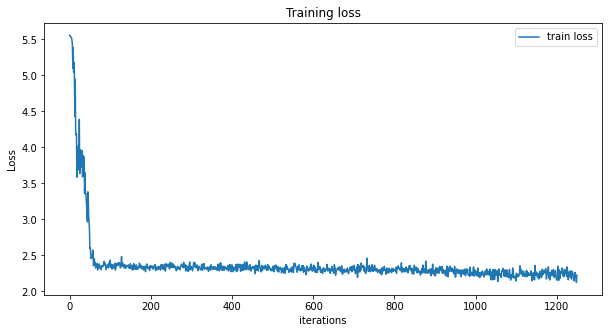

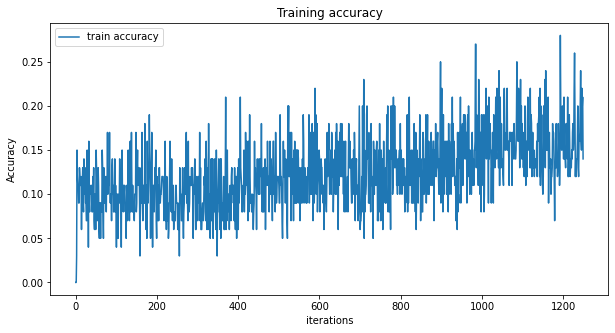

In [14]:
plt.figure(figsize=(10,5))
plt.title("Training loss")
plt.plot(train_loss,label="train loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training accuracy")
plt.plot(train_acc,label="train accuracy")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [11]:
p = figure(y_axis_label='Loss', width=850, y_range=(0, 5), title='PyTorch ConvNet results')
p.extra_y_ranges = {'Accuracy': Range1d(start=0, end=100)}
p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')
p.line(np.arange(len(train_loss)), train_loss, color='green')
p.line(np.arange(len(train_loss)), np.array(train_acc) * 100, y_range_name='Accuracy', color='red')
show(p)

In [36]:
lambda_l1 = 0.001
lambda_l2 = 0.001

In [39]:
# L1 Regularization

# Train the model
total_step = len(train_loader)
train_loss = []
train_acc = []

tb = SummaryWriter()

for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0
    for i, (images, labels) in enumerate(train_loader):
            
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss.append(loss.item())
        total_loss += loss.item()

        # Backprop
        optimizer.zero_grad()
        
        l1_norm = sum(param.abs().sum() for param in model.parameters())
        loss = loss + lambda_l1 * l1_norm
        
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        total_correct += (predicted == labels).sum().item()
        train_acc.append(correct / total)

    tb.add_scalar("L1 Train Loss", total_loss/len(part_train), epoch)
    tb.add_scalar("L1 Train Accuracy", total_correct/len(part_train), epoch)
        
    print('Epoch [{}/{}], Step [{}/{}], training Loss: {:.4f}, training Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i + 1, total_step, total_loss/len(part_train),
                      (total_correct / len(part_train)) * 100))

    
tb.close()

Epoch [1/6], Step [250/250], training Loss: 0.0300, training Accuracy: 9.98%
Epoch [2/6], Step [250/250], training Loss: 0.0232, training Accuracy: 10.62%
Epoch [3/6], Step [250/250], training Loss: 0.0223, training Accuracy: 14.69%
Epoch [4/6], Step [250/250], training Loss: 0.0221, training Accuracy: 16.15%
Epoch [5/6], Step [250/250], training Loss: 0.0220, training Accuracy: 17.22%
Epoch [6/6], Step [250/250], training Loss: 0.0218, training Accuracy: 18.00%


In [45]:
# L2 Regularization

# Train the model
total_step = len(train_loader)
train_loss = []
train_acc = []

tb = SummaryWriter()

for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0
    for i, (images, labels) in enumerate(train_loader):
            
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss.append(loss.item())
        total_loss += loss.item()

        # Backprop
        optimizer.zero_grad()
        
        #l1_norm = sum(param.abs().sum() for param in model.parameters())
        #loss = loss + lambda_l1 * l1_norm
        
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + lambda_l1 * l2_norm
        
        
        
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        total_correct += (predicted == labels).sum().item()
        train_acc.append(correct / total)

    tb.add_scalar("L2 Train Loss", total_loss/len(part_train), epoch)
    tb.add_scalar("L2 Train Accuracy", total_correct/len(part_train), epoch)
        
    print('Epoch [{}/{}], Step [{}/{}], training Loss: {:.4f}, training Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i + 1, total_step, total_loss/len(part_train),
                      (total_correct / len(part_train)) * 100))

    
tb.close()

Epoch [1/6], Step [250/250], training Loss: 0.0282, training Accuracy: 17.78%
Epoch [2/6], Step [250/250], training Loss: 0.0197, training Accuracy: 35.59%
Epoch [3/6], Step [250/250], training Loss: 0.0148, training Accuracy: 44.81%
Epoch [4/6], Step [250/250], training Loss: 0.0136, training Accuracy: 50.04%
Epoch [5/6], Step [250/250], training Loss: 0.0126, training Accuracy: 53.67%
Epoch [6/6], Step [250/250], training Loss: 0.0118, training Accuracy: 57.52%
